**Алгоритмы анализа данных**

**Урок 4. Деревья решений**

Домашнее задание №4.

[1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)](#task_1)


[2. *Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.](#task_2)

In [25]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)
# classification_data, classification_labels = make_circles(n_samples=30, random_state=5)

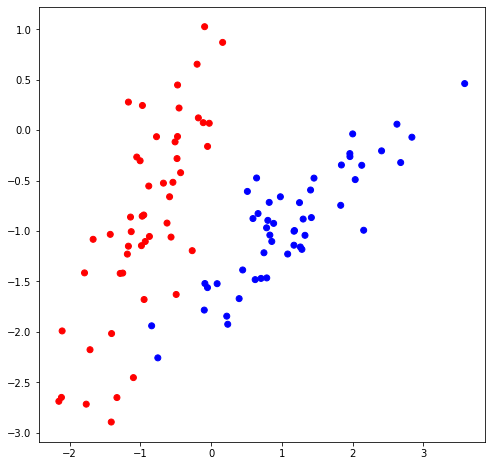

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);


In [6]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

<h3><a id='task_1'>1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)</a></h3>

In [22]:
class MyTreeClassifier:
    _root = None
    _max_depth = None
    _max_features = None
    _min_leaves = None


    def __init__(self, max_depth=None, max_features=None, min_leaves=3):
        self._max_depth = max_depth
        self._max_features = max_features
        self._min_leaves = min_leaves


    def _split(self, data, labels, column_index, threshold):
        left = np.where(data[:, column_index] <= threshold)
        right = np.where(data[:, column_index] > threshold)
            
        true_data = data[left]
        false_data = data[right]
        
        true_labels = labels[left]
        false_labels = labels[right]
            
        return true_data, false_data, true_labels, false_labels


    def _gini(self, labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        
        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2
            
        return impurity


    def _gain(self, left_labels, right_labels, root_gini):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return root_gini - p * self._gini(left_labels) - (1 - p) * self._gini(right_labels)        


    def _find_best_split(self, data, labels):
        #  обозначим минимальное количество объектов в узле
        min_samples_leaf = self._min_leaves
        root_gini = self._gini(labels)

        best_gain = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])
            
            for t in t_values:
                true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)

                if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                    continue
                
                current_gain = self._gain(true_labels, false_labels, root_gini)
                
                #  выбираем порог, на котором получается максимальный прирост качества
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index

        return best_gain, best_t, best_index


    def _build_tree(self, data, labels, current_depth):
        # print(f'current_depth = {current_depth} max_depth = {self._max_depth}')

        gain, t, index = self._find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if gain == 0:
            return Leaf(data, labels)

        if self._max_depth:
            if current_depth > self._max_depth:
                return Leaf(data, labels)

        # check feature number
        if self._max_features:
            n_features = min(data.shape[1], self._max_features)
        else:
            n_features = data.shape[1]

        data_to_check = data[:, :n_features]
        true_data, false_data, true_labels, false_labels = self._split(data_to_check, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self._build_tree(true_data, true_labels, current_depth+1)

        false_branch = self._build_tree(false_data, false_labels, current_depth+1)
        
        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)


    def fit(self, X, y):
        self._root = self._build_tree(X, y, 0)
        
        return self._root


    def _classify_object(self, obj, node):
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self._classify_object(obj, node.true_branch)
        else:
            return self._classify_object(obj, node.false_branch)


    def predict(self, data):
        classes = []
        for obj in data:
            prediction = self._classify_object(obj, self._root)
            classes.append(prediction)
        return classes

    # Напечатаем ход нашего дерева
    def _print_tree(self, node, spacing=""):

        # Если лист, то выводим его прогноз
        if isinstance(node, Leaf):
            print(spacing + "Прогноз:", node.prediction)
            return

        # Выведем значение индекса и порога на этом узле
        print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

        # Рекурсионный вызов функции на положительном поддереве
        print(spacing + '--> True:')
        self._print_tree(node.true_branch, spacing + "  ")

        # Рекурсионный вызов функции на отрицательном поддереве
        print(spacing + '--> False:')
        self._print_tree(node.false_branch, spacing + "  ")
        
    def print(self):
        self._print_tree(self._root)






In [9]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [10]:
test = MyTreeClassifier(max_depth=20, max_features=1, min_leaves=1)

In [11]:
test.fit(train_data, train_labels)

In [12]:
res = test.predict(train_data)

In [13]:
test.print()

Индекс 0 <= 0.16261402870113306
--> True:
  Индекс 0 <= -0.11161924805848533
  --> True:
    Индекс 0 <= -0.8725985883473684
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0 <= -0.8411814419026544
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 0
  --> False:
    Индекс 0 <= -0.05163250299323496
    --> True:
      Индекс 0 <= -0.09195833713035761
      --> True:
        Индекс 0 <= -0.09712237000978252
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 1
    --> False:
      Индекс 0 <= -0.02676286201867817
      --> True:
        Прогноз: 0
      --> False:
        Индекс 0 <= 0.08490007282712542
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
--> False:
  Прогноз: 1


In [14]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [15]:
# Получим ответы для обучающей выборки 
train_answers = test.predict(train_data)

In [16]:
# И получим ответы для тестовой выборки
answers = test.predict(test_data)

In [17]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

100.0

In [18]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

In [19]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(model: MyTreeClassifier, train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(model.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

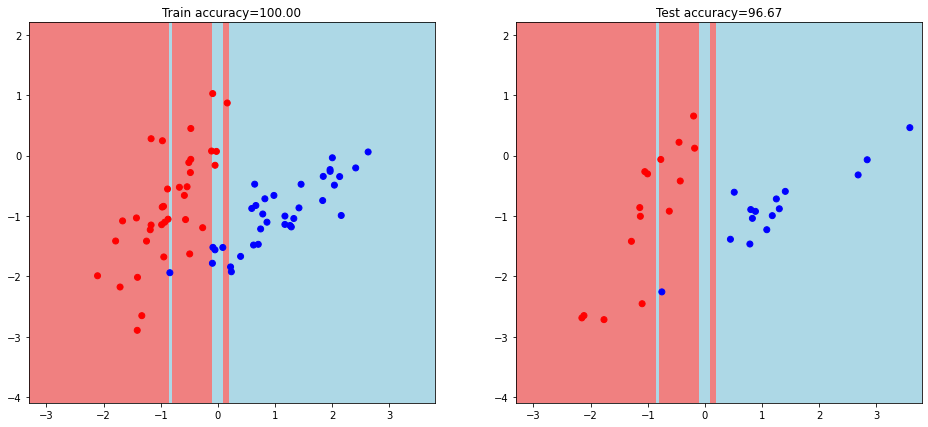

In [21]:
visualize(test, train_data, test_data)

<h3><a id='task_2'>2. *Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.</a></h3>

В случае **регрессии** разброс будет характеризоваться дисперсией или же *среднеквадратичным отклонением*, поэтому критерий информативности будет записан в виде

$$H(X) = \frac{1}{X}\sum_{i\in X}(y_{i} - \bar{y}(X))^{2},$$

или же *среднеабсолютным отклонением*:

$$H(X) = \frac{1}{X}\sum_{i\in X}(|y_{i} - \bar{y}(X)|),$$


где $\bar{y}(X)$ - среднее значение ответа в выборке $X$:

$$\bar{y}(X) = \frac{1}{|X|}\sum_{i\in X}y_{i}.$$

In [23]:
class MyTreeRegression:
    _root = None
    _max_depth = None
    _max_features = None
    _min_leaves = None


    def __init__(self, max_depth=None, max_features=None, min_leaves=3):
        self._max_depth = max_depth
        self._max_features = max_features
        self._min_leaves = min_leaves


    def _split(self, data, labels, column_index, threshold):
        left = np.where(data[:, column_index] <= threshold)
        right = np.where(data[:, column_index] > threshold)
            
        true_data = data[left]
        false_data = data[right]
        
        true_labels = labels[left]
        false_labels = labels[right]
            
        return true_data, false_data, true_labels, false_labels


    def _mse(self, array):
      mean = array.mean()
      return np.mean((array - mean)**2)


    def _gain(self, left_array, right_array, criterion):
        p = float(left_array.shape[0]) / (left_array.shape[0] + right_array.shape[0])
        return criterion - p * self._mse(left_array) - (1 - p) * self._mse(right_array)        


    def _find_best_split(self, data, labels):
        #  обозначим минимальное количество объектов в узле
        min_samples_leaf = self._min_leaves
        root_mse = self._mse(labels)

        best_gain = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])
            
            for t in t_values:
                true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)

                if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                    continue
                
                current_gain = self._gain(true_labels, false_labels, root_mse)
                
                #  выбираем порог, на котором получается максимальный прирост качества
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index

        return best_gain, best_t, best_index


    def _build_tree(self, data, labels, current_depth):
        # print(f'current_depth = {current_depth} max_depth = {self._max_depth}')

        gain, t, index = self._find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if gain == 0:
            return Leaf(data, labels)

        if self._max_depth:
            if current_depth > self._max_depth:
                return Leaf(data, labels)

        # check feature number
        if self._max_features:
            n_features = min(data.shape[1], self._max_features)
        else:
            n_features = data.shape[1]

        data_to_check = data[:, :n_features]
        true_data, false_data, true_labels, false_labels = self._split(data_to_check, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self._build_tree(true_data, true_labels, current_depth+1)

        false_branch = self._build_tree(false_data, false_labels, current_depth+1)
        
        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)


    def fit(self, X, y):
        self._root = self._build_tree(X, y, 0)
        
        return self._root


    def _classify_object(self, obj, node):
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self._classify_object(obj, node.true_branch)
        else:
            return self._classify_object(obj, node.false_branch)


    def predict(self, data):
        classes = []
        for obj in data:
            prediction = self._classify_object(obj, self._root)
            classes.append(prediction)
        return classes

    # Напечатаем ход нашего дерева
    def _print_tree(self, node, spacing=""):

        # Если лист, то выводим его прогноз
        if isinstance(node, Leaf):
            print(spacing + "Прогноз:", node.prediction)
            return

        # Выведем значение индекса и порога на этом узле
        print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

        # Рекурсионный вызов функции на положительном поддереве
        print(spacing + '--> True:')
        self._print_tree(node.true_branch, spacing + "  ")

        # Рекурсионный вызов функции на отрицательном поддереве
        print(spacing + '--> False:')
        self._print_tree(node.false_branch, spacing + "  ")
        
    def print(self):
        self._print_tree(self._root)






In [36]:
# сгенерируем данные
regression_data, regression_labels = make_regression(n_samples=100, n_features=1, n_informative=1, n_targets=1, bias=0.0, effective_rank=None, tail_strength=0.5, noise=10.0, shuffle=True, coef=False, random_state=None)


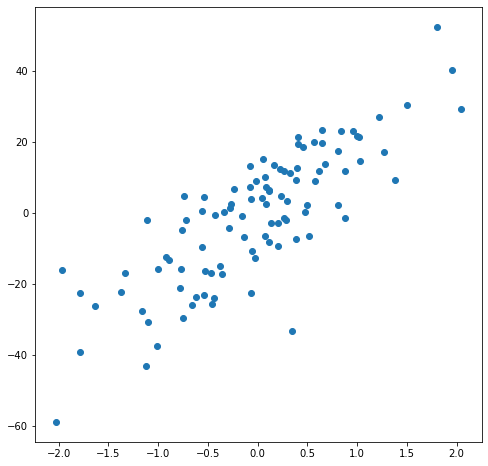

In [37]:
plt.figure(figsize=(8,8))
plt.scatter(regression_data, regression_labels);

In [38]:
train_X, test_X, train_y, test_y = train_test_split(regression_data, 
                                                                    regression_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [40]:
my_reg_model = MyTreeRegression(max_depth=100, max_features=100, min_leaves=5)

In [41]:
my_reg_model.fit(train_X, train_y)

In [45]:
result = my_reg_model.predict(test_X)

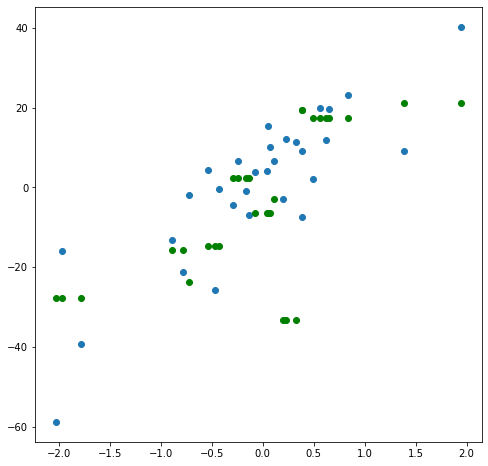

In [47]:
plt.figure(figsize=(8,8))
plt.scatter(test_X, test_y)
plt.scatter(test_X, result,c='g')